# Deep Learning with PyTorch : Build a Generative Adversarial Network

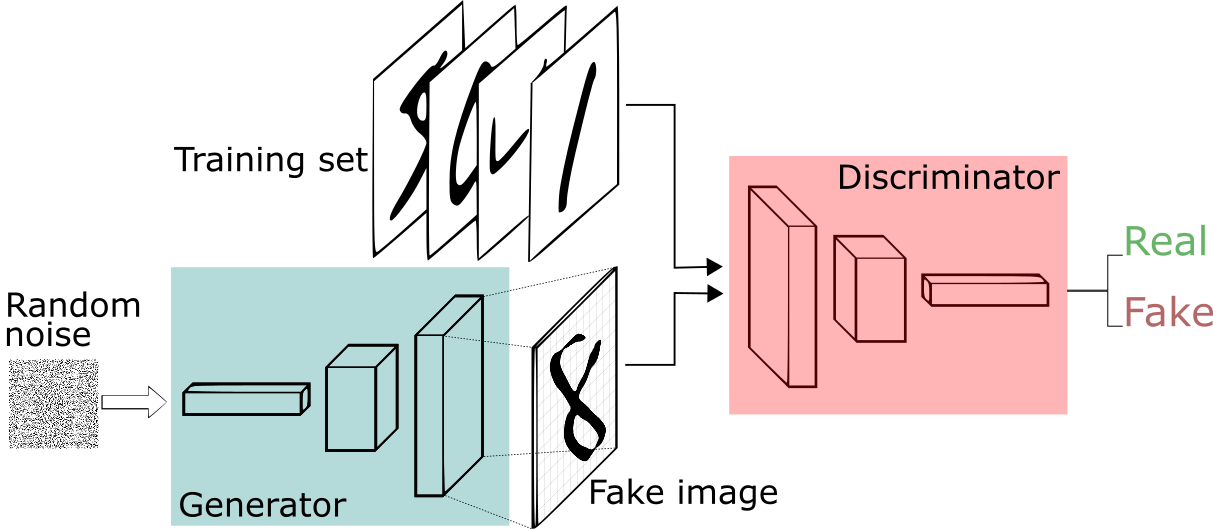

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [3]:
device = 'cuda'
batch_size = 128  # train loader, training loop
noise_dim = 64    # generator model

# optimizer params
lr = 0.0002
beta_1 = 0.5  # these 2 are going to pass to the adam optimizer
beta_2 = 0.99

# training variables
epochs = 20

# Load MNIST Dataset

In [4]:
from torchvision import datasets, transforms as T

In [5]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor(), #(h, w, c) -> (c, h, w)
])

In [6]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.59MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



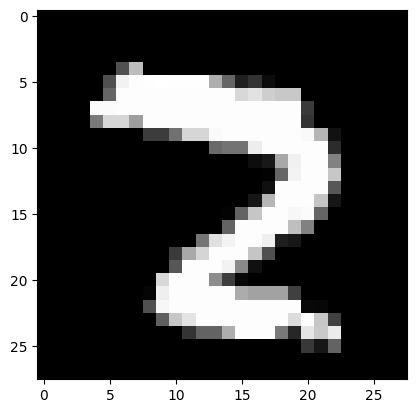

In [9]:
image, label = trainset[28]

plt.imshow(image.squeeze(), cmap='gray') # the image is gray scale

In [10]:
print('total images:', len(trainset))

total images: 60000


# Load Dataset Into Batches

In [11]:
from torch.utils.data import DataLoader
'''Batches data for training
Shuffles data for better training
Supports parallel data loading'''

from torchvision.utils import make_grid # to create a grid of images from  batch
'''Visualizes batches of images
Compares images easily'''

'Visualizes batches of images\nCompares images easily'

In [12]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [13]:
print('total batches:', len(trainloader))

total batches: 469


In [14]:
dataiter = iter(trainloader)
images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [15]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

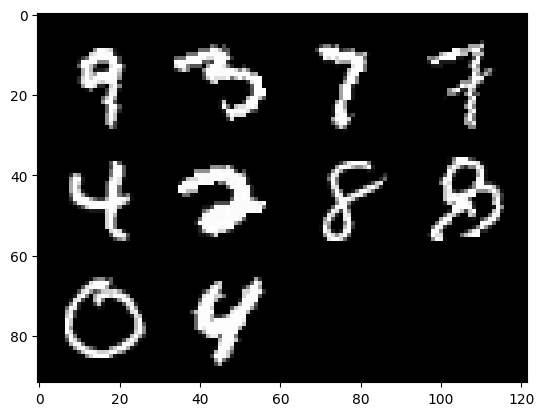

In [16]:
show_tensor_images(images, num_images=10)

# Create Discriminator Network

In [17]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [19]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_l = get_disc_block(1, 16, (3, 3), 2)
        self.block_2 = get_disc_block(16, 32, (5, 5), 2)
        self.block_3 = get_disc_block(32, 64, (5, 5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x1 = self.block_l(x)
        x2 = self.block_2(x1)  # Use output from block_l
        x3 = self.block_3(x2)  # Use output from block_2

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [26]:
from torch import nn
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [27]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if not final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [28]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2)
        self.block_2 = get_gen_block(256, 128, (4, 4), 1)
        self.block_3 = get_gen_block(128, 64, (3, 3), 2)

        self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, noise_vec):
      #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [30]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
              Tanh-2            [-1, 256, 3, 3]               0
   ConvTranspose2d-3            [-1, 128, 6, 6]         524,416
              Tanh-4            [-1, 128, 6, 6]               0
   ConvTranspose2d-5           [-1, 64, 13, 13]          73,792
              Tanh-6           [-1, 64, 13, 13]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
       BatchNorm2d-8            [-1, 1, 28, 28]               2
              ReLU-9            [-1, 1, 28, 28]               0
Total params: 746,947
Trainable params: 746,947
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 2.85
Estimated Total Size (MB): 3.14
-------------------------------------------

In [31]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [32]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [33]:
# both are used to make generator and Discriminator loss

def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()  # to pass the output without sigmoid activation
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, torch.zeros_like(disc_pred))
  return loss

In [34]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 1.6530615405233176 | G_loss: 1.0459835282683437e-08


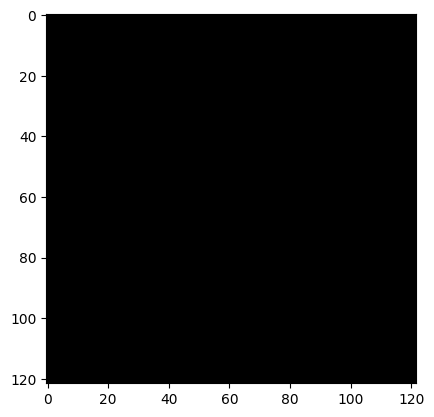

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.8879827912936586 | G_loss: 3.4268019547304602e-09


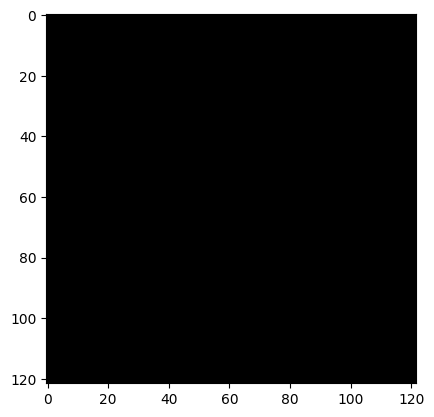

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.8316510525593626 | G_loss: 2.710141955439762e-09


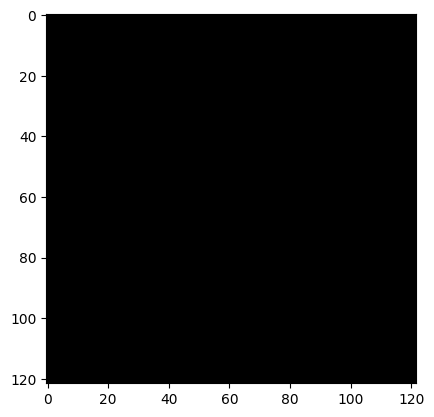

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.8070924604879514 | G_loss: 2.5128454787238727e-09


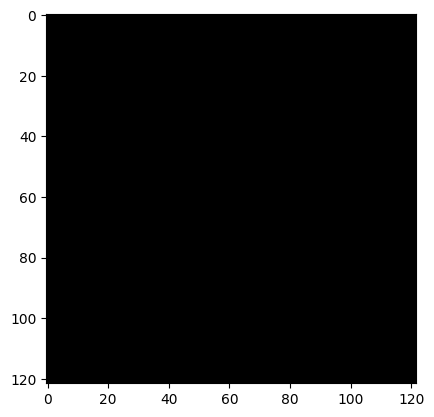

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.7913267191793365 | G_loss: 2.5607587985647955e-09


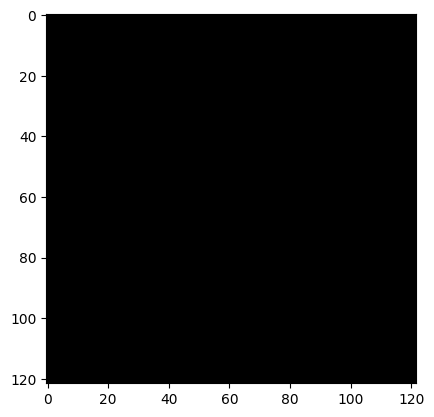

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.7815699370176807 | G_loss: 2.631871772401757e-09


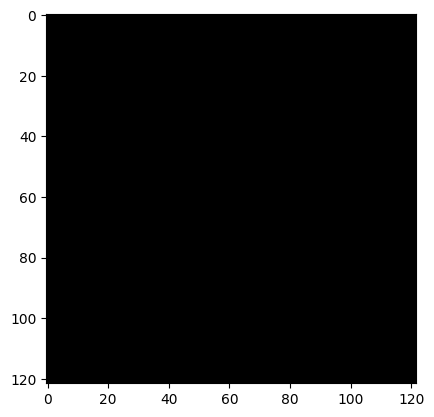

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.7748181626740803 | G_loss: 2.791709188862194e-09


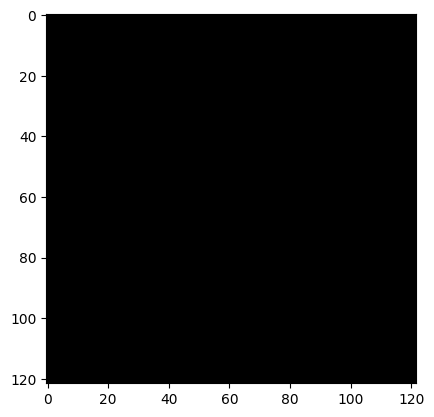

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.7690326791328154 | G_loss: 3.015086693936162e-09


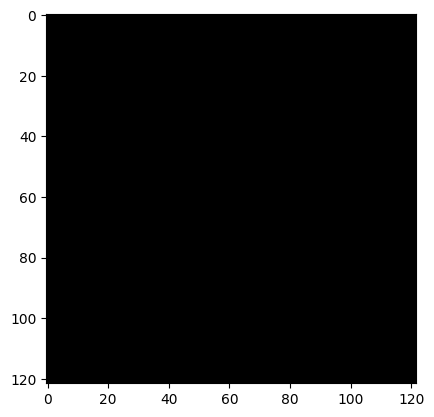

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.7637798140552252 | G_loss: 3.304645651178925e-09


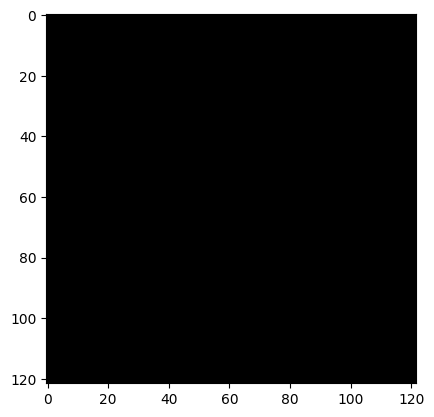

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.7616860088763207 | G_loss: 3.6152341977685478e-09


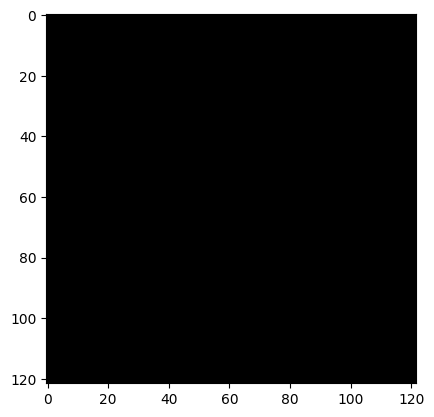

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.7554933296591997 | G_loss: 3.941000698016351e-09


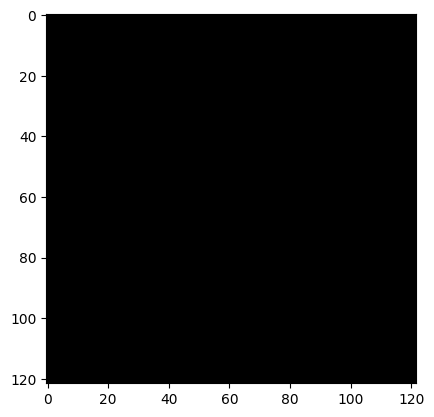

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.7550123105171138 | G_loss: 4.288898415284248e-09


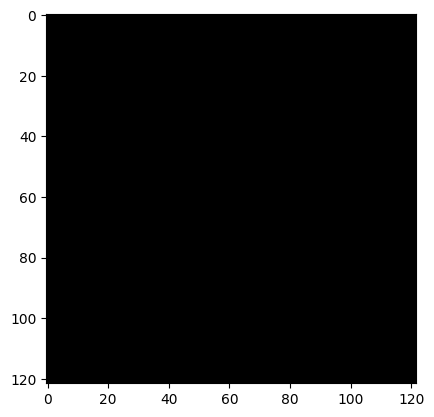

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.7511717665678402 | G_loss: 4.674543519384141e-09


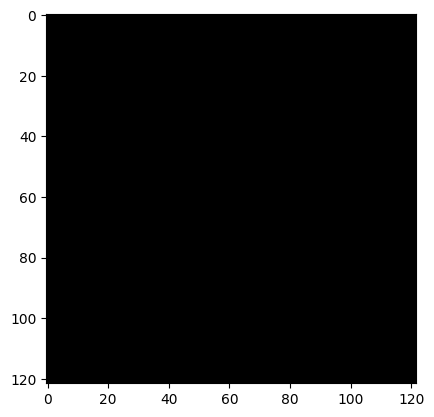

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.7478976849553935 | G_loss: 5.124787812310923e-09


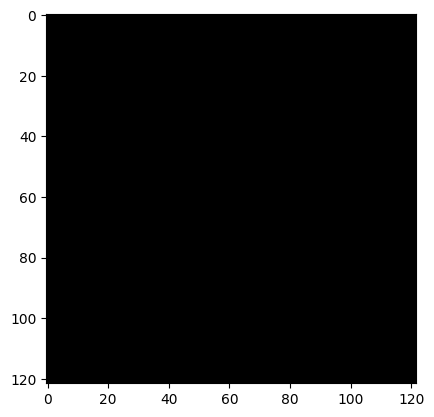

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.7476598503493043 | G_loss: 5.5284679568228655e-09


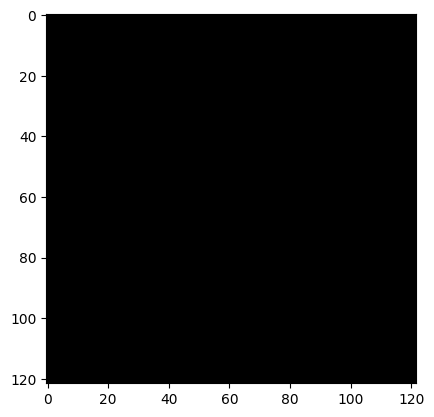

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.7442636525453027 | G_loss: 5.97481439069446e-09


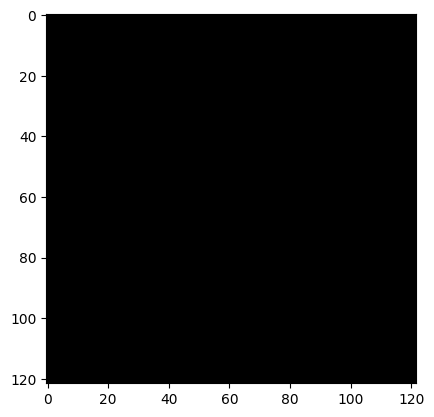

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.744040310382843 | G_loss: 6.526635983142429e-09


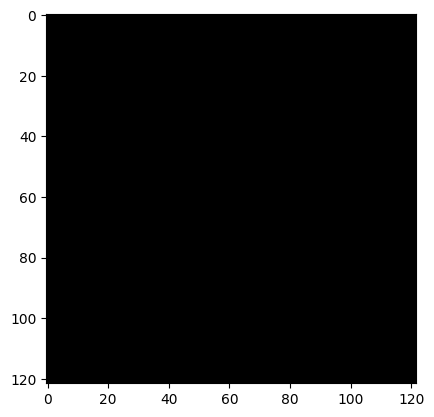

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.7406779835219068 | G_loss: 7.090099639354504e-09


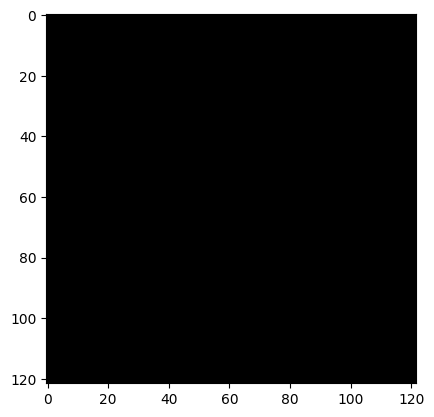

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.739424669030887 | G_loss: 7.709907667047326e-09


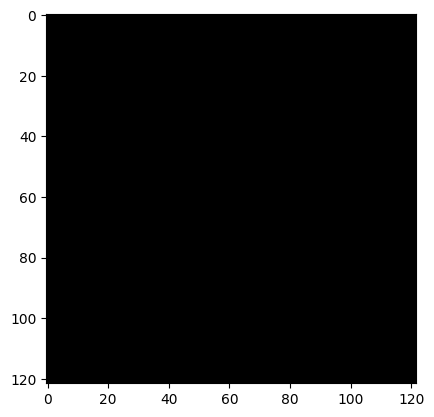

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.7375503601804216 | G_loss: 8.405747317339502e-09


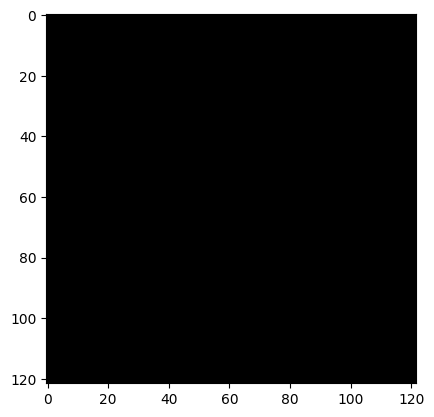

In [40]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    D_opt.zero_grad()

    fake_img = G(noise)

    D_pred = D(real_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_real_loss + D_fake_loss) / 2

    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()


    # finding loss and updating weights for generator

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print('Epoch: {} | D_loss: {} | G_loss: {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

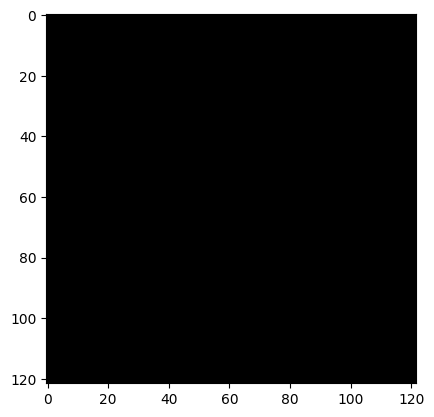

In [41]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)